In [1]:
!wandb login

wandb: Currently logged in as: itaywolf (use `wandb login --relogin` to force relogin)


In [2]:
import wandb

wandb.init(project="asl_dl", entity="itaywolf")

wandb: Currently logged in as: itaywolf (use `wandb login --relogin` to force relogin)


In [3]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [4]:
# train_data_path = r'C:\technion\semester_8\project_b\datasets\significant\Training_Set'
train_data_path = r'C:\technion\semester_8\project_b\datasets\large\asl_alphabet_train\asl_alphabet_train'

In [5]:
test_size = 0.1
val_size = 0.2
batch_size = 32
num_epoch = 10
learning_rate = 0.01 # 0.1->0.01
num_classes = 25 # 29->26->25

wandb.config = {
  "test_size": 0.1,
  "val_size" : 0.2,
  "batch_size": 32,
  "num_epoch": 10,
  "learning_rate": 0.01,
  "num_classes": 25 # 29->26->25
}

In [6]:
rand_brightness = transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=(0.5,1.5))],p=0.2)
rand_contrast = transforms.RandomApply(transforms=[transforms.ColorJitter(contrast=(0.8,1.2))],p=0.2)
rand_saturation = transforms.RandomApply(transforms=[transforms.ColorJitter(saturation=(0.5,1.5))],p=0.05)
rand_hue = transforms.RandomApply(transforms=[transforms.ColorJitter(hue=(-0.1,0.1))],p=0)
rand_padding50 = transforms.RandomApply(transforms=[transforms.Pad(50)],p=0.1)
rand_padding100 = transforms.RandomApply(transforms=[transforms.Pad(100)],p=0.1)
rand_gaussian_blur = transforms.RandomApply(transforms=[transforms.GaussianBlur(kernel_size=5,sigma=(0.1,2))],p=0.15)
rand_perspective = transforms.RandomPerspective(distortion_scale=0.4,p=0.05)
rand_horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
grayscale = transforms.Grayscale(3)

train_transforms = transforms.Compose([
    # rand_brightness, # rand_contrast, rand_saturation, rand_hue, rand_padding50, rand_padding100, rand_gaussian_blur, rand_perspective, rand_horizontal_flip,
    # grayscale,
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    # grayscale,
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [7]:
%%time
train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
num_train_samples = len(train_dataset)
train_dataset

CPU times: total: 141 ms
Wall time: 142 ms


Dataset ImageFolder
    Number of datapoints: 75000
    Root location: C:\technion\semester_8\project_b\datasets\large\asl_alphabet_train\asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [8]:
%%time
val_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)
val_dataset

CPU times: total: 125 ms
Wall time: 139 ms


Dataset ImageFolder
    Number of datapoints: 75000
    Root location: C:\technion\semester_8\project_b\datasets\large\asl_alphabet_train\asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [9]:
%%time
test_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)
test_dataset

CPU times: total: 141 ms
Wall time: 141 ms


Dataset ImageFolder
    Number of datapoints: 75000
    Root location: C:\technion\semester_8\project_b\datasets\large\asl_alphabet_train\asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [10]:
torch.manual_seed(1)
indices = torch.randperm(num_train_samples)

use = 0.25
split_to_use = int(num_train_samples * use)
# train_dataset = torch.utils.data.Subset(train_dataset, indices[split_to_use:])
# val_dataset = torch.utils.data.Subset(val_dataset, indices[split_to_use:])

# indices = torch.randperm(split_to_use)
split_test = int(split_to_use * test_size)
split_val = int((split_to_use - split_test) * val_size) + split_test


test_dataset = torch.utils.data.Subset(test_dataset, indices[:split_test])
val_dataset = torch.utils.data.Subset(val_dataset, indices[split_test:split_val])
train_dataset = torch.utils.data.Subset(train_dataset, indices[split_val:split_to_use])


len(train_dataset), len(val_dataset), len(test_dataset)

(13500, 3375, 1875)

In [11]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=1)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=1)

In [12]:
classes = train_dataloader.dataset.dataset.classes

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
model = torchvision.models.resnet50(pretrained=True)
#model

In [15]:
for param in model.parameters():
    param.requires_grad = False

In [16]:
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)
# model

In [17]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7) # 0.9->0.7
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
from tqdm import tqdm
from time import time

print_every = 1000*use*0.5
steps = 0
train_losses, val_losses = [], []

wandb.watch(model, criterion, log="all", log_freq=print_every)

model.to(device)
for epoch in tqdm(range(num_epoch)):
    iterations = 0
    running_loss = 0
    correct_train = 0
    total_train = 0
    start_time = time()

    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        steps += 1
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        total_train += labels.size(0)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterations += 1
        running_loss += loss.item()

        if steps % print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}]. Train loss {running_loss / steps}.', end=' ')
            print(f'Train acc {correct_train / total_train * 100}.', end=' ')
            with torch.no_grad():
                model.eval()
                correct_val, total_val = 0, 0
                val_loss = 0
                all_preds = torch.tensor([])
                all_labels = torch.tensor([])
                all_preds = all_preds.to(device)
                all_labels = all_labels.to(device)
                for images, labels in val_dataloader:
                    images = images.to(device)
                    labels = labels.to(device)

                    output = model(images)
                    all_preds = torch.cat(
                        (all_preds, output)
                        ,dim=0
                    )
                    all_labels = torch.cat(
                        (all_labels, labels)
                        ,dim=0
                    )

                    loss = criterion(output, labels)
                    val_loss += loss.item()

                    correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                    total_val += labels.size(0)

                stacked = torch.stack(
                    (
                        all_labels
                        ,all_preds.argmax(dim=1)
                    )
                    ,dim=1
                )

            print(f'Val loss {val_loss / len(val_dataloader)}. Val acc {correct_val / total_val * 100}')

            wandb.log({"epoch": epoch + 1, "train_loss": running_loss / steps, "train_acc": correct_train / total_train * 100}, step=steps)
            wandb.log({"val_loss": val_loss / len(val_dataloader), "val_acc": correct_val / total_val * 100}, step=steps)

            train_losses.append(running_loss / total_train)
            val_losses.append(val_loss / total_val)
    scheduler.step()
    print("learning rate is",scheduler.get_last_lr())

    print(f'Epoch took {time() - start_time}')
    # torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}') # save only if better

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [125]/[422]. Train loss 3.5727177734375. Train acc 46.025001525878906. Val loss 1.0674382130492408. Val acc 67.5851821899414
Epoch [1]/[10]. Batch [250]/[422]. Train loss 2.2151383831501006. Train acc 60.26250076293945. Val loss 0.6091740423778318. Val acc 79.82221984863281
Epoch [1]/[10]. Batch [375]/[422]. Train loss 1.7045622629324595. Train acc 66.57499694824219. Val loss 0.5427866558421333. Val acc 83.2592544555664


 10%|█         | 1/10 [00:44<06:41, 44.59s/it]

learning rate is [0.006999999999999999]
Epoch took 44.58712601661682
Epoch [2]/[10]. Batch [78]/[422]. Train loss 0.07680258712172508. Train acc 84.3349380493164. Val loss 0.449221975328225. Val acc 86.1629638671875
Epoch [2]/[10]. Batch [203]/[422]. Train loss 0.13898420308232307. Train acc 86.28385925292969. Val loss 0.30151339388399756. Val acc 89.89629364013672
Epoch [2]/[10]. Batch [328]/[422]. Train loss 0.1721778594106436. Train acc 87.49047088623047. Val loss 0.3665339434343689. Val acc 88.79999542236328


 20%|██        | 2/10 [01:27<05:47, 43.46s/it]

learning rate is [0.004899999999999999]
Epoch took 42.66926908493042
Epoch [3]/[10]. Batch [31]/[422]. Train loss 0.010641204595565796. Train acc 90.12096405029297. Val loss 0.22110988424634034. Val acc 91.82221984863281
Epoch [3]/[10]. Batch [156]/[422]. Train loss 0.03412460962124169. Train acc 92.42788696289062. Val loss 0.21217949955530888. Val acc 92.9481430053711
Epoch [3]/[10]. Batch [281]/[422]. Train loss 0.05423528960843881. Train acc 92.70462036132812. Val loss 0.28791903598972085. Val acc 91.022216796875
Epoch [3]/[10]. Batch [406]/[422]. Train loss 0.06675547145754099. Train acc 92.99568176269531. Val loss 0.21209997528250207. Val acc 92.62222290039062


 30%|███       | 3/10 [02:16<05:21, 45.93s/it]

learning rate is [0.003429999999999999]
Epoch took 48.86967468261719
Epoch [4]/[10]. Batch [109]/[422]. Train loss 0.016318001809445294. Train acc 93.03325653076172. Val loss 0.17067262184155998. Val acc 93.95555114746094
Epoch [4]/[10]. Batch [234]/[422]. Train loss 0.024899655108650526. Train acc 94.63141632080078. Val loss 0.1715008127063794. Val acc 94.13333129882812
Epoch [4]/[10]. Batch [359]/[422]. Train loss 0.034023893868693936. Train acc 94.85549926757812. Val loss 0.16065086477067111. Val acc 94.4888916015625


 40%|████      | 4/10 [02:58<04:28, 44.68s/it]

learning rate is [0.002400999999999999]
Epoch took 42.75123190879822
Epoch [5]/[10]. Batch [62]/[422]. Train loss 0.0056816583818623. Train acc 94.50604248046875. Val loss 0.1551737579042619. Val acc 94.4000015258789
Epoch [5]/[10]. Batch [187]/[422]. Train loss 0.010674670199056466. Train acc 96.34024810791016. Val loss 0.1530777492542874. Val acc 94.96295928955078
Epoch [5]/[10]. Batch [312]/[422]. Train loss 0.016145373140461744. Train acc 96.56449890136719. Val loss 0.1436553720630846. Val acc 95.05184936523438


 50%|█████     | 5/10 [03:43<03:43, 44.63s/it]

learning rate is [0.0016806999999999992]
Epoch took 44.560452699661255
Epoch [6]/[10]. Batch [15]/[422]. Train loss 0.0010615447005804847. Train acc 94.79167175292969. Val loss 0.13894631642461666. Val acc 95.37776947021484
Epoch [6]/[10]. Batch [140]/[422]. Train loss 0.0046919918761899075. Train acc 97.70089721679688. Val loss 0.15271418886083477. Val acc 94.60740661621094
Epoch [6]/[10]. Batch [265]/[422]. Train loss 0.008075962644266455. Train acc 97.84198760986328. Val loss 0.15145646054121964. Val acc 94.99259185791016
Epoch [6]/[10]. Batch [390]/[422]. Train loss 0.011338403238356113. Train acc 97.90866088867188. Val loss 0.12342702749378558. Val acc 95.79259490966797


 60%|██████    | 6/10 [04:34<03:07, 46.94s/it]

learning rate is [0.0011764899999999994]
Epoch took 51.40766000747681
Epoch [7]/[10]. Batch [93]/[422]. Train loss 0.003988962676198709. Train acc 96.13574981689453. Val loss 0.1217678258423957. Val acc 95.9111099243164
Epoch [7]/[10]. Batch [218]/[422]. Train loss 0.006156732928346504. Train acc 97.67774963378906. Val loss 0.13092879900041055. Val acc 95.55555725097656
Epoch [7]/[10]. Batch [343]/[422]. Train loss 0.00839112450150044. Train acc 98.03207397460938. Val loss 0.11819551227051976. Val acc 96.11851501464844


 70%|███████   | 7/10 [05:19<02:18, 46.11s/it]

learning rate is [0.0008235429999999996]
Epoch took 44.41779017448425
Epoch [8]/[10]. Batch [46]/[422]. Train loss 0.0012241384449104469. Train acc 98.09782409667969. Val loss 0.11416075937449932. Val acc 95.73332977294922
Epoch [8]/[10]. Batch [171]/[422]. Train loss 0.0031648389174044134. Train acc 98.77558135986328. Val loss 0.11595834029030125. Val acc 96.29629516601562
Epoch [8]/[10]. Batch [296]/[422]. Train loss 0.004907665763193598. Train acc 98.83868408203125. Val loss 0.102124593058109. Val acc 96.62222290039062
Epoch [8]/[10]. Batch [421]/[422]. Train loss 0.006286289501659296. Train acc 98.93112182617188. 

 80%|████████  | 8/10 [06:09<01:35, 47.55s/it]

Val loss 0.1091643522036666. Val acc 96.29629516601562
learning rate is [0.0005764800999999997]
Epoch took 50.6180100440979
Epoch [9]/[10]. Batch [124]/[422]. Train loss 0.00289933385034757. Train acc 97.75704956054688. Val loss 0.11879681763327066. Val acc 96.23703002929688
Epoch [9]/[10]. Batch [249]/[422]. Train loss 0.004265693421507704. Train acc 98.54417419433594. Val loss 0.10460384226105404. Val acc 96.50370025634766
Epoch [9]/[10]. Batch [374]/[422]. Train loss 0.0055488953437656165. Train acc 98.75501251220703. Val loss 0.10467360023286124. Val acc 96.59259033203125


 90%|█████████ | 9/10 [06:55<00:46, 46.85s/it]

learning rate is [0.00040353606999999974]
Epoch took 45.309266090393066
Epoch [10]/[10]. Batch [77]/[422]. Train loss 0.001570834478062968. Train acc 97.68669128417969. Val loss 0.10507904033545616. Val acc 96.80000305175781
Epoch [10]/[10]. Batch [202]/[422]. Train loss 0.0025367210232652725. Train acc 98.85519409179688. Val loss 0.10056111640911901. Val acc 96.68148040771484
Epoch [10]/[10]. Batch [327]/[422]. Train loss 0.003584107499400323. Train acc 99.08257293701172. Val loss 0.10201160887801. Val acc 96.5333251953125


100%|██████████| 10/10 [07:37<00:00, 45.78s/it]

learning rate is [0.0002824752489999998]
Epoch took 42.633381843566895


In [20]:
torch.save(model.state_dict(), r'C:\Users\wolf_\PycharmProjects\project_b\wandb\model_easy_set.pth')

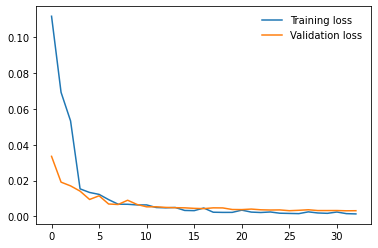

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [22]:
wandb.finish()

In [23]:
cmt = torch.zeros(num_classes,num_classes, dtype=torch.int64)

for p in stacked:
    tl, pl = p.tolist()
    tl, pl = int(tl),int(pl)
    cmt[tl, pl] = cmt[tl, pl] + 1

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
tensor([[0.9603, 0.0000, 0.0000, 0.0000, 0.0079, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0079, 0.0000, 0.0000, 0.0000, 0.0079, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0159, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0068, 0.0068, 0.9660, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0068, 0.0000, 0.0000, 0.0000, 0.0068,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0068],
        [0.0149, 0.0075, 0.0000, 0.0000, 0.9478, 0.0000, 0.0

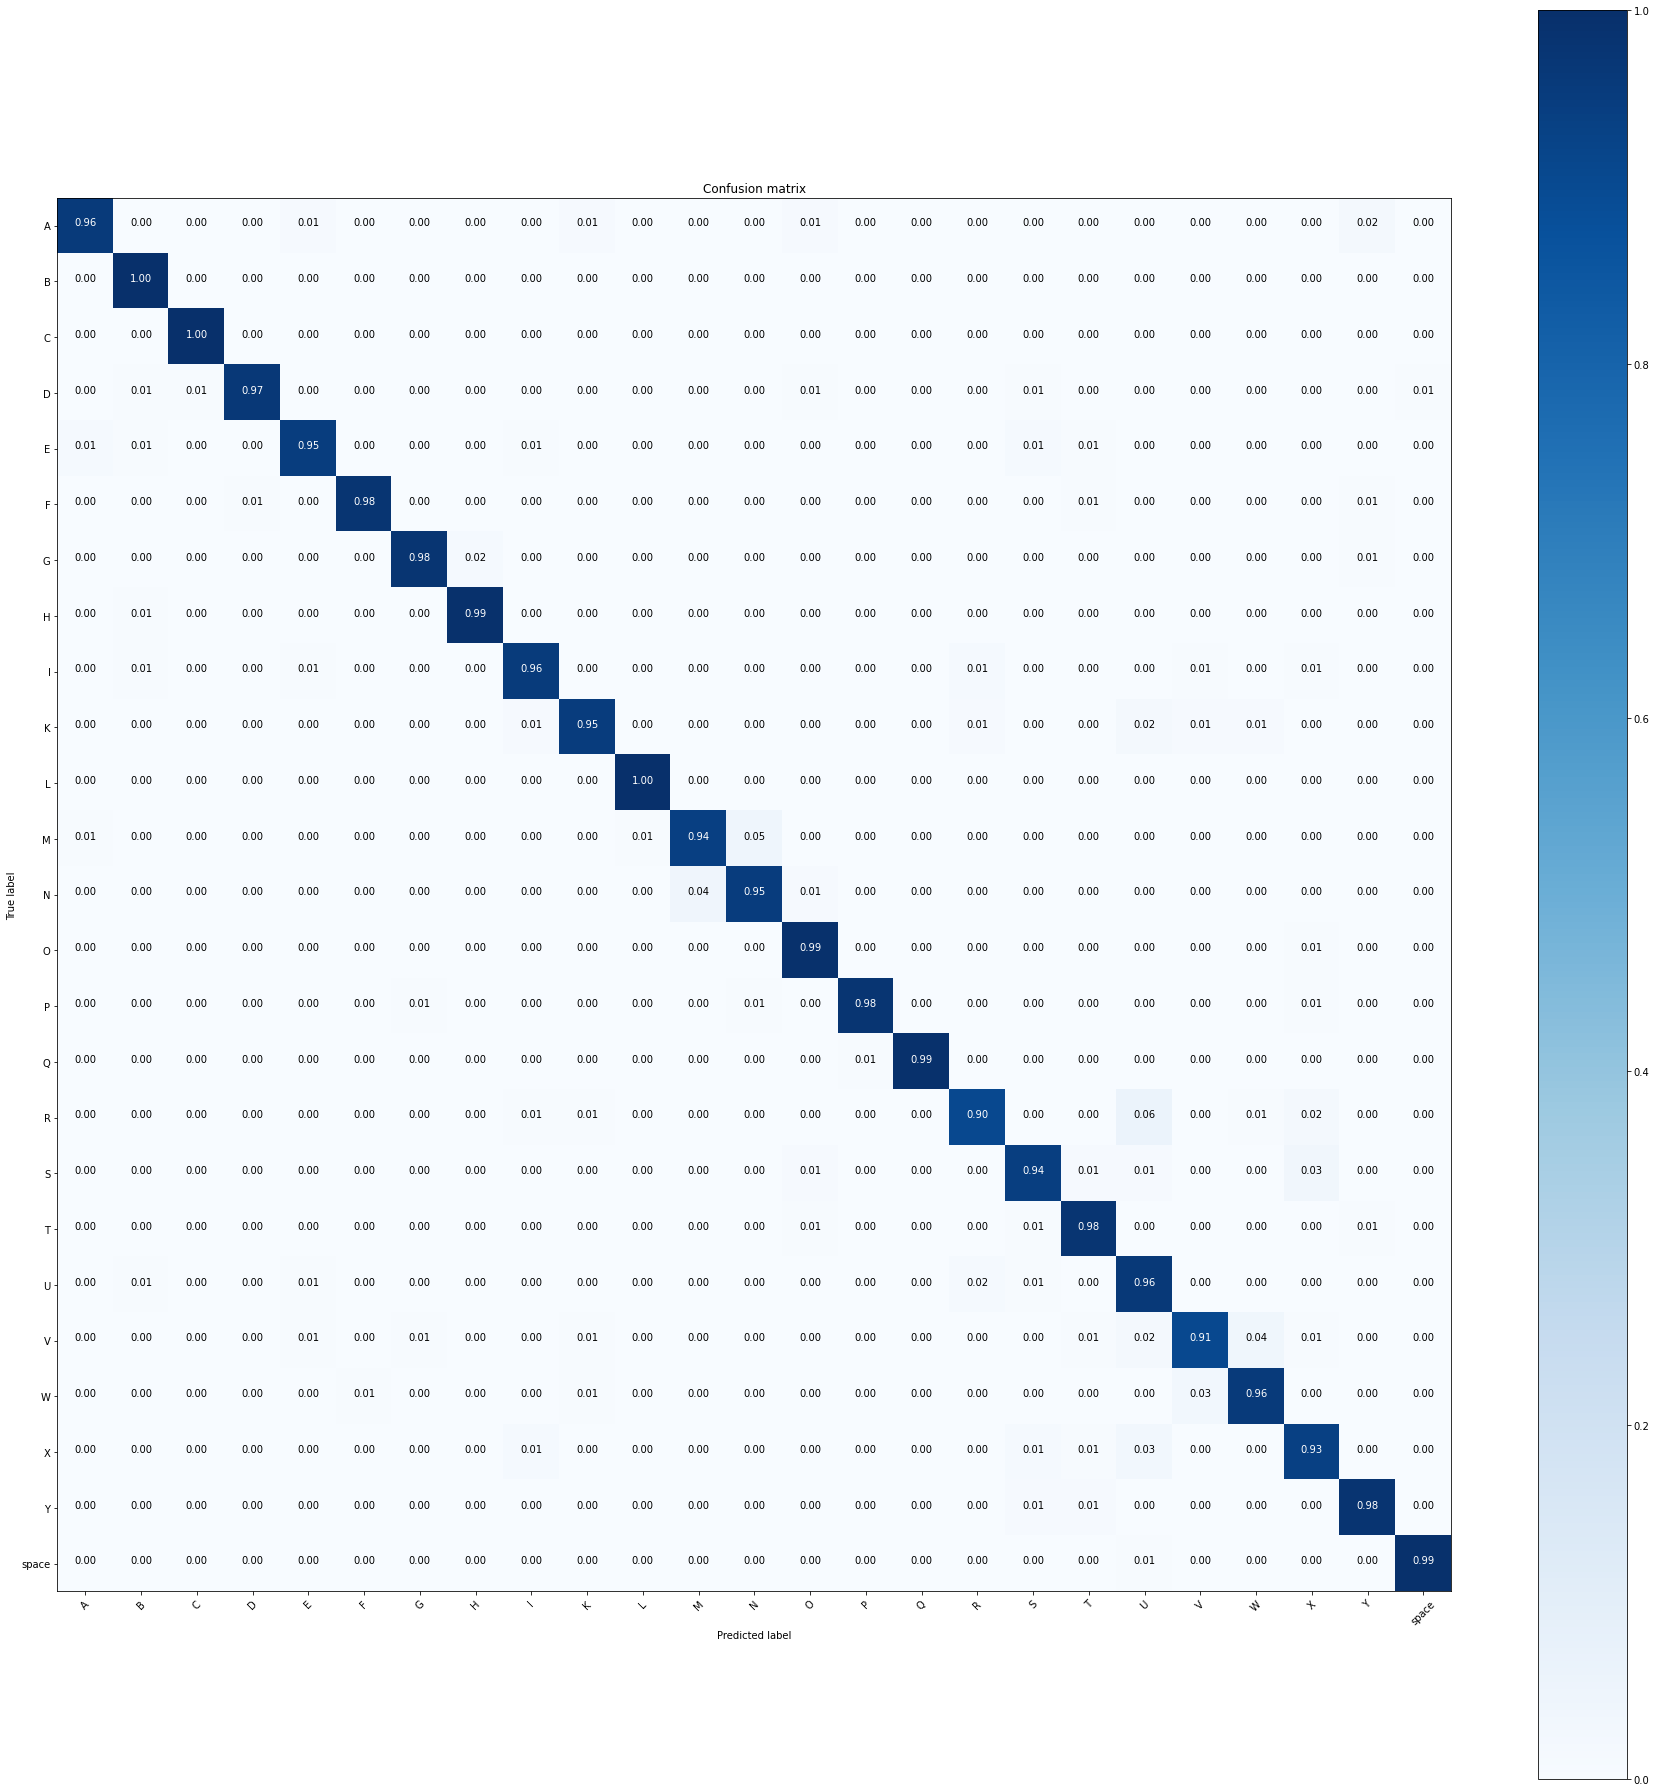

In [25]:
plt.figure(figsize=(num_classes,num_classes))
plot_confusion_matrix(cmt, classes, normalize=True)

In [ ]:
######################################################
###### Below is not relevant
######################################################

In [26]:
print(cmt)


tensor([[121,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   1,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0],
        [  0, 145,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 137,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   1,   1, 142,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
           0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1],
        [  2,   1,   0,   0, 127,   0,   0,   0,   1,   0,   0,   0,   0,   0,
           0,   0,   0,   2,   1,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   1,   0, 143,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0],
        [  0,   0,   0,   0,   0,   0, 128,   2,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   1

In [27]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=1)

In [28]:
# from pathlib import Path
# from PIL import Image
#
#
# test_data_path = Path('../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/')
#
#
# class ASLTestDataset(torch.utils.data.Dataset):
#     def __init__(self, root_path, transforms=None):
#         super().__init__()
#
#         self.transforms = transforms
#         self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
#
#     def __len__(self):
#         return len(self.imgs)
#
#     def __getitem__(self, idx):
#         img_path = self.imgs[idx]
#         img = Image.open(img_path).convert('RGB')
#
#         label = img_path.parts[-1].split('_')[0]
#         if self.transforms:
#             img = self.transforms(img)
#
#         return img, label

In [29]:
len(test_dataloader)
type(test_dataloader)

torch.utils.data.dataloader.DataLoader

In [30]:
classes = test_dataloader.dataset.dataset.classes


AttributeError: 'NoneType' object has no attribute '_log'

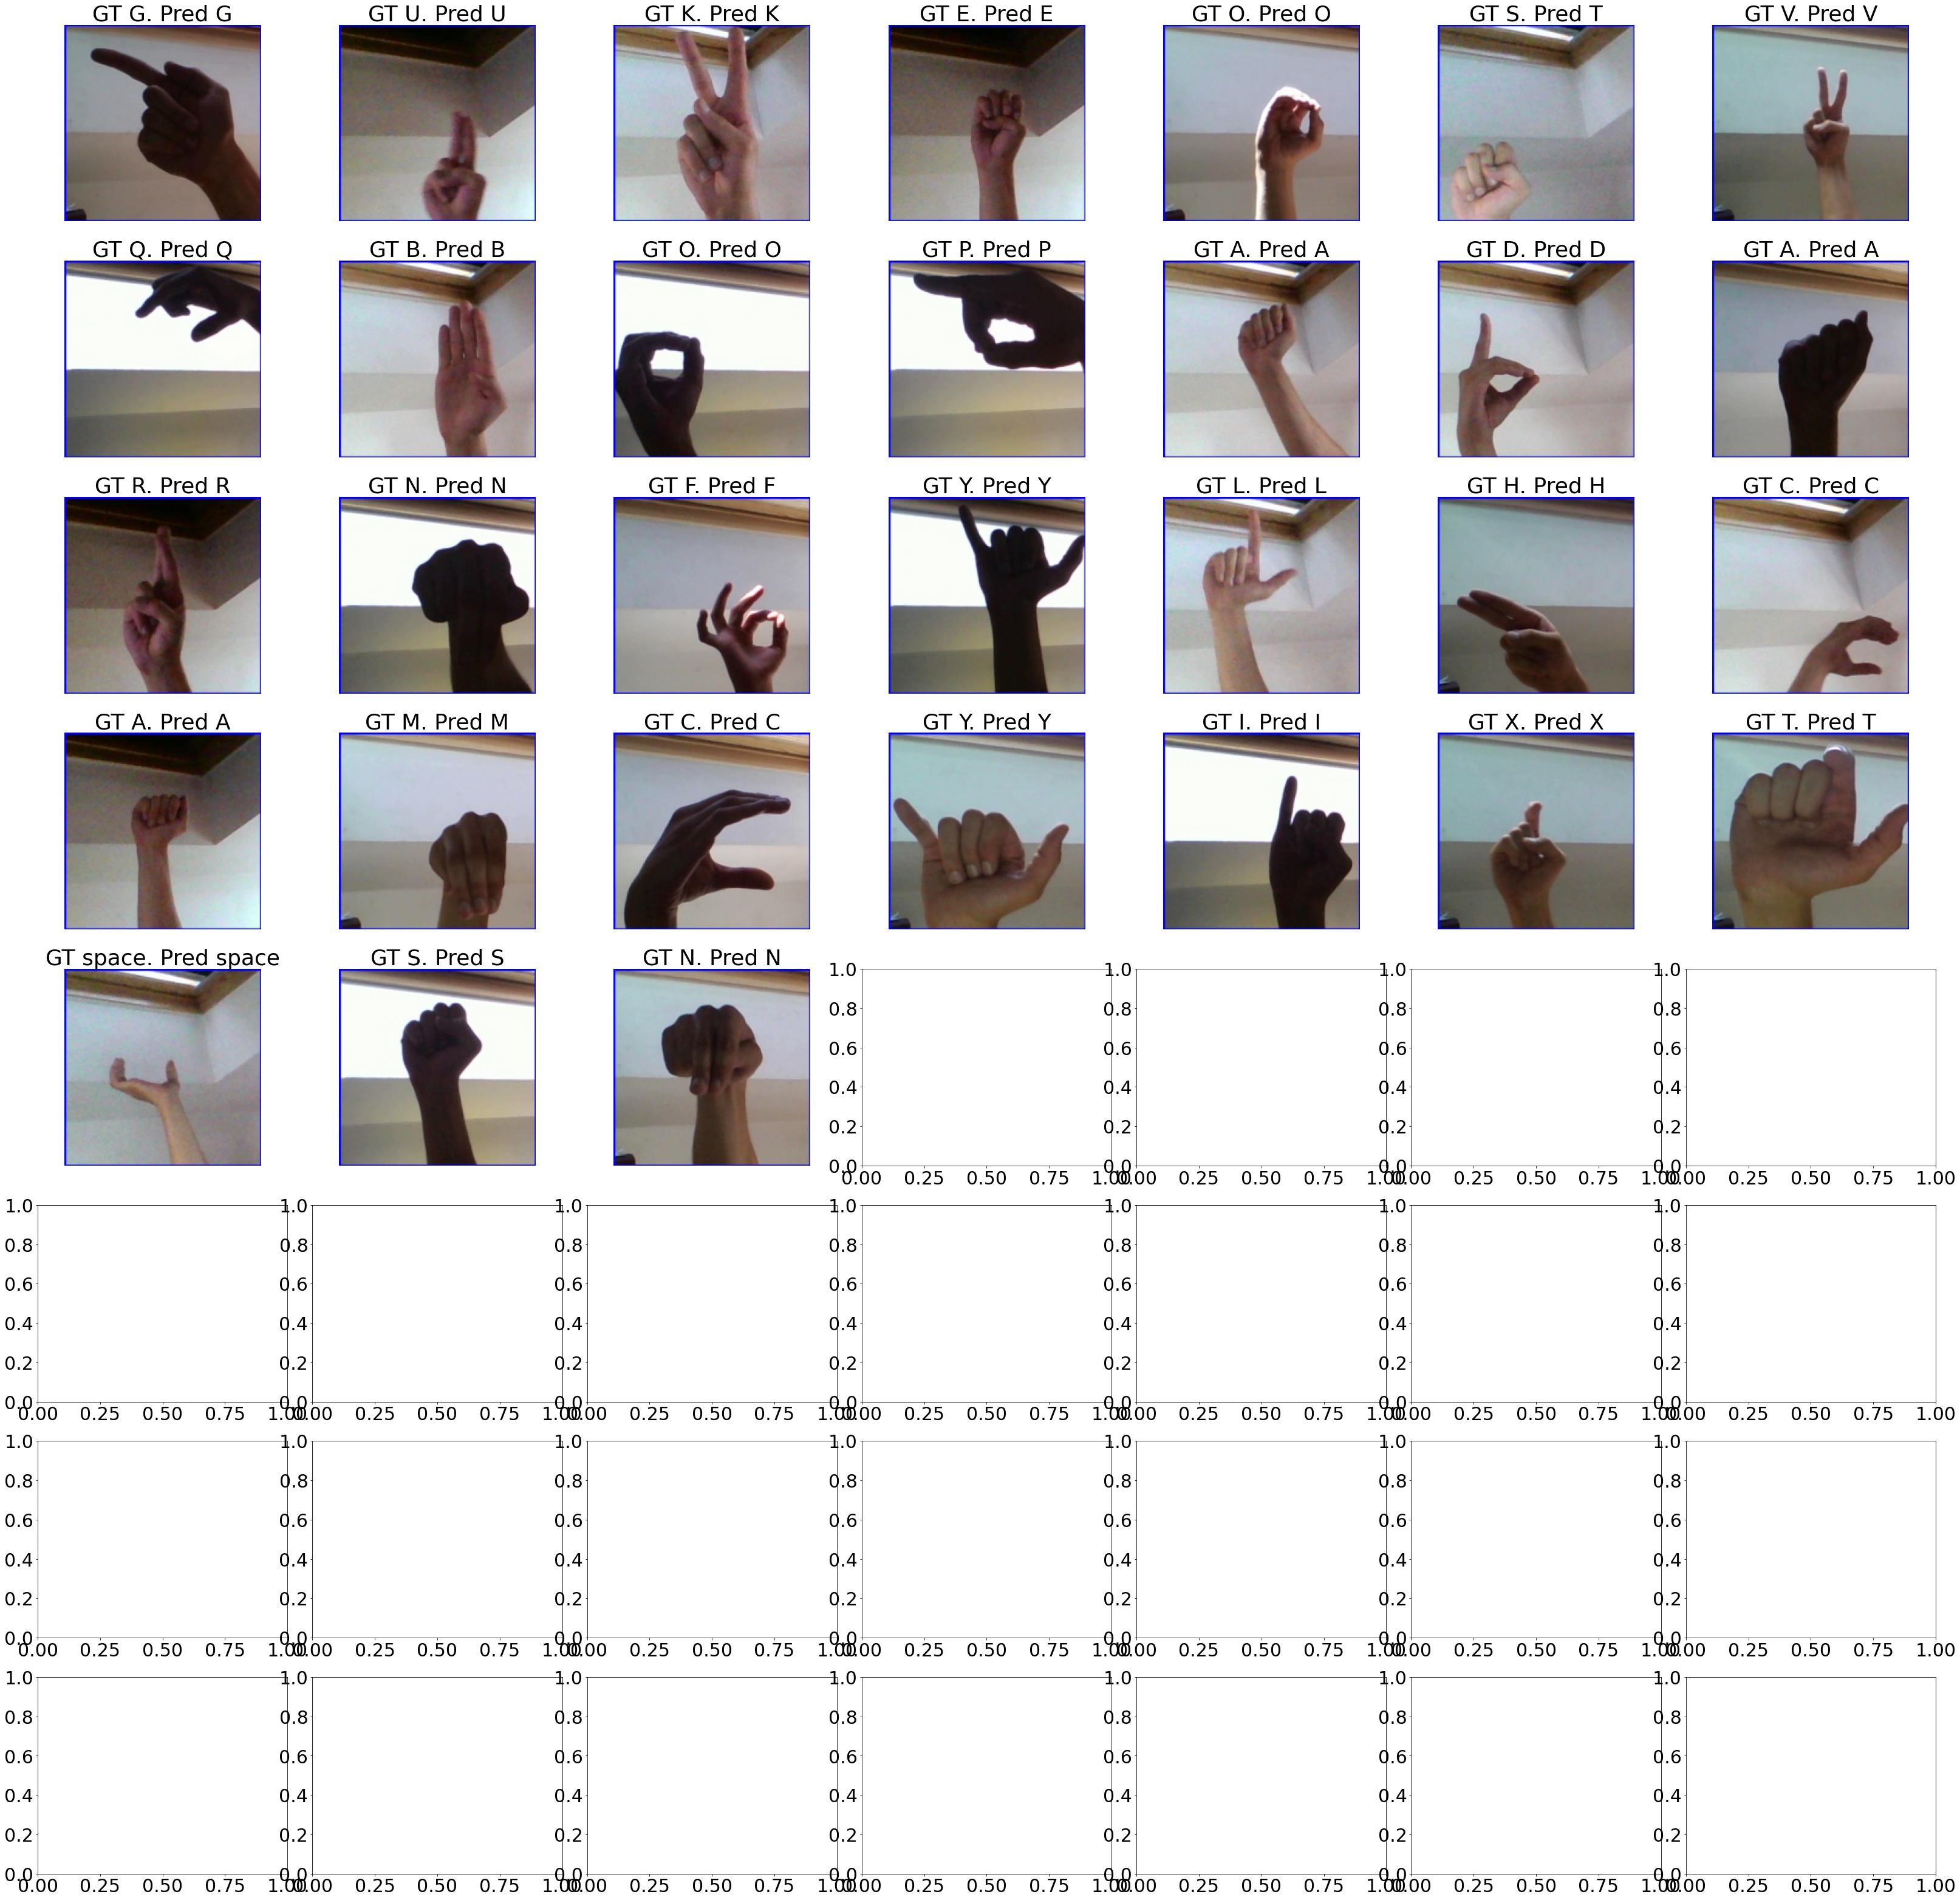

In [31]:
columns = 7
test_limit = 51
# row = round(len(test_dataloader) / columns)
row = round(test_limit / columns)+1

plt.rcParams.update({'font.size': 30})

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
test_counter = 1
mismatch_counter = 0
for images, labels in test_dataloader:
    # test_counter += 1
    # if test_counter < 100:
    #     continue
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)

    ax[i][j].imshow(images[0].cpu().permute(1, 2, 0))
    ax[i][j].set_title(f'GT {classes[labels[0]]}. Pred {classes[torch.max(output, dim=1)[1]]}')
    ax[i][j].axis('off')
    if classes[labels[0]] != classes[torch.max(output, dim=1)[1]]:
        mismatch_counter += 1

    j += 1
    if j == columns:
        j = 0
        i += 1


    # print(test_counter)
    if test_counter >= test_limit:
        break
print(mismatch_counter)
plt.show()

In [ ]:
video_frame = r'C:\technion\semester_8\project_b\videos_frame'

In [ ]:
frame_dataset = datasets.ImageFolder(video_frame, transform=test_transforms)
video_samples = len(frame_dataset)
frame_dataset

In [ ]:
frame_dataloader = torch.utils.data.DataLoader(dataset=frame_dataset,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=1)

In [ ]:
columns = 7
test_limit = 51
# row = round(len(frame_dataloader) / columns)+1
# row = round(test_limit / columns)+1

plt.rcParams.update({'font.size': 30})

# fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
# plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
test_counter = 1
mismatch_counter = 0
for images, labels in frame_dataloader:
    # test_counter += 1
    # if test_counter < 100:
    #     continue
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)

    print(f'GT {classes[labels[0]]}. Pred {classes[torch.max(output, dim=1)[1]]}')
    plt.imshow(images[0].cpu().permute(1, 2, 0))
    plt.axis('off')

    # ax[i][j].imshow(images[0].cpu().permute(1, 2, 0))
    # ax[i][j].set_title(f'GT {classes[labels[0]]}. Pred {classes[torch.max(output, dim=1)[1]]}')
    # ax[i][j].axis('off')
    if classes[labels[0]] != classes[torch.max(output, dim=1)[1]]:
        mismatch_counter += 1

    j += 1
    if j == columns:
        j = 0
        i += 1


    # print(test_counter)
    if test_counter >= test_limit:
        break
print(mismatch_counter)
plt.show()